# NLP Final Project

You have a collection of ~30 days’ worth of news articles in RCC located at: /home/kadochnikov/news/news_chicago_il.pkl – related to either Chicago and / or Illinois.

To complete your assignment, I suggest considering the following steps:

Clean-up the noise (eliminate articles irrelevant to the analysis)

Detect major topics

Identify top reasons for population decline (negative sentiment)

Suggest corrective actions

Demonstrate how the city / state can attract new businesses (positive sentiment)

Leverage appropriate NLP techniques to identify organizations and people and apply targeted sentiment

Why businesses should stay in IL or move into IL?

Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)

Why residents should stay in IL or move into IL?

Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)


In [166]:
# imports

import string
import bz2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import nltk.corpus  
import time
import math
import re
from sklearn.model_selection import train_test_split
from nltk.text import Text
from nltk.corpus import stopwords
from itertools import combinations
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob import TextBlob
from nltk.stem.wordnet import WordNetLemmatizer
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from keras.layers import Bidirectional, GlobalMaxPool1D,GlobalMaxPool2D, GlobalMaxPool3D,Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline
plt.style.use('fivethirtyeight')

import spacy
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
from gensim import corpora, models

In [28]:
# Import sf classifiers

from graphviz import Source
java_path = "C:/Program Files (x86)/Java/jdk1.8.0_162/bin/java.exe"
# java_path = "C:\ProgramData\Oracle\Java\javapath\java.exe"
os.environ['JAVAHOME'] = java_path

# Change the path according to your system
stanford_classifier = 'D:\datascience\StanfordParser\stanford-ner-2017-06-09\classifiers\english.all.3class.distsim.crf.ser.gz'
stanford_ner_path = 'D:\datascience\StanfordParser\stanford-ner-2017-06-09\stanford-ner.jar'

stanford_parser_path = 'D:\datascience\StanfordParser\stanford-parser-full-2017-06-09\stanford-parser.jar'
stanford_parser_models_path = 'D:\datascience\StanfordParser\stanford-parser-full-2017-06-09\stanford-parser-3.8.0-models.jar'

from nltk.parse.stanford import StanfordDependencyParser
from nltk.tag.stanford import StanfordNERTagger

# Creating Tagger Object
st = StanfordNERTagger(stanford_classifier, stanford_ner_path, encoding='utf-8')
sdp = StanfordDependencyParser(path_to_jar=stanford_parser_path, path_to_models_jar=stanford_parser_models_path)

c:\users\boog\dev\cfehome\lib\site-packages\nltk\tag\stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


In [29]:
# import

news = pd.read_pickle('../final/news_chicago_il.pkl')

### Let's extract some of the top kw and topics

We'll use tf-idf and lda to begih with.

In [30]:
news.head()

,crawled,language,text,title
0,2018-01-22T06:31:13.011+02:00,english,Discussion in ' Midwest ' started by sportscra...,Best Stops Chicago Red Line?
1,2018-01-22T06:43:12.000+02:00,english,CHICAGO – Hundreds of ballet dancers between t...,AP PHOTOS: Talented young dancers compete in C...
2,2018-01-22T06:52:12.009+02:00,english,Chicago rapper Fredo Santana has reportedly di...,Chicago Rapper Fredo Santana Reportedly Dead A...
3,2018-01-22T06:53:16.017+02:00,english,E-mail \nPolice are searching for a 27-year-ol...,"Man, 27, reported missing from Rogers Park | C..."
4,2018-01-22T06:54:04.067+02:00,english,Documentary about Miss Continental pageant set...,Documentary about Miss Continental pageant set...


In [28]:
 # other languages?
news.language.unique()

array(['english'], dtype=object)

In [31]:
# parsing date
news['date'] = pd.to_datetime(news.crawled.str[:10])

In [32]:
# remove special characters
news['text_cleaned'] = news['text'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))

In [33]:
# remove special characters
news['title_clean'] = news['title'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))

### I also will use spacy for data cleansing

In [171]:
nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])
stops = stopwords.words("english")

def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

news['text_cleaneded'] = news['text_cleaned'].apply(normalize,lowercase=True,remove_stopwords=True)

In [173]:
news.head()

,crawled,language,text,title,date,text_clean,title_clean,pred_class,labels,text_cleaned
0,2018-01-22T06:31:13.011+02:00,english,Discussion in ' Midwest ' started by sportscra...,Best Stops Chicago Red Line?,2018-01-22,Discussion in Midwest started by sportscraze...,Best Stops Chicago Red Line,0.977709,1,"discussion midwest start sportscrazed2 , jan 2..."
1,2018-01-22T06:43:12.000+02:00,english,CHICAGO – Hundreds of ballet dancers between t...,AP PHOTOS: Talented young dancers compete in C...,2018-01-22,CHICAGO Hundreds of ballet dancers between th...,AP PHOTOS: Talented young dancers compete in C...,0.330031,0,chicago hundred ballet dancer age 9 19 auditio...
2,2018-01-22T06:52:12.009+02:00,english,Chicago rapper Fredo Santana has reportedly di...,Chicago Rapper Fredo Santana Reportedly Dead A...,2018-01-22,Chicago rapper Fredo Santana has reportedly di...,Chicago Rapper Fredo Santana Reportedly Dead A...,0.921612,1,"chicago rapper fredo santana reportedly die , ..."
3,2018-01-22T06:53:16.017+02:00,english,E-mail \nPolice are searching for a 27-year-ol...,"Man, 27, reported missing from Rogers Park | C...",2018-01-22,Email Police are searching for a 27yearold man...,"Man, 27, reported missing from Rogers Park Ch...",0.061736,0,email police search 27yearold man go miss roge...
4,2018-01-22T06:54:04.067+02:00,english,Documentary about Miss Continental pageant set...,Documentary about Miss Continental pageant set...,2018-01-22,Documentary about Miss Continental pageant set...,Documentary about Miss Continental pageant set...,0.023161,0,documentary miss continental pageant set debut...


Are the news article distributed by a particular date?

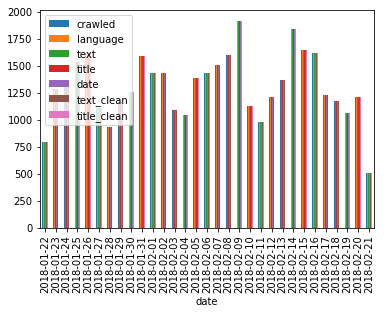

In [11]:
news.groupby(news["date"].dt.date).count().plot(kind="bar")

Pretty even spread, should not be a signficant risk to one outsized date (say a terrorist attack)

Establish functions below

In [33]:
def tf(word, blob):
    return blob.words.count(word) / len(blob.words)
# tf(word, blob) computes "term frequency" which is the number of times a word appears in a document blob, 
# normalized by dividing by the total number of words in blob. We use TextBlob for breaking up the text into words 
# and getting the word counts.


def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)
# n_containing(word, bloblist) returns the number of documents containing word. 
# A generator expression is passed to the sum() function.


def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))
# idf(word, bloblist) computes "inverse document frequency" which measures how common a word is 
# among all documents in bloblist. The more common a word is, the lower its idf. 
# We take the ratio of the total number of documents to the number of documents containing word, 
# then take the log of that. Add 1 to the divisor to prevent division by zero


def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)
# tfidf(word, blob, bloblist) computes the TF-IDF score. It is simply the product of tf and idf.

In [34]:
bloblist = []
del bloblist[:]

for i  in range(0,len(news)):
    bloblist.append(TextBlob(news['text_cleaned'].iloc[i]))
    
len(bloblist)  

40585

### Change with stopwords and vecs

In [ ]:
countvect = CountVe

### Now run in for tf idf of text and title

In [14]:
for i, blob in enumerate(bloblist):
# Print top 5 values
    if i == 5:
        break
    print("Top words in news {}".format(i + 1))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:10]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

Top words in news 1
	Word: sportscrazed2, TF-IDF: 0.1681
	Word: MonDak_Joe1953, TF-IDF: 0.1681
	Word: 5toutman75, TF-IDF: 0.08405
	Word: 673, TF-IDF: 0.07818
	Word: Aspirant, TF-IDF: 0.07343
	Word: Aragon, TF-IDF: 0.06756
	Word: Initiate, TF-IDF: 0.06643
	Word: walk, TF-IDF: 0.06384
	Word: Hop, TF-IDF: 0.06139
	Word: Berwyn, TF-IDF: 0.05748
Top words in news 2
	Word: dancers, TF-IDF: 0.11683
	Word: semifinals.Chicago, TF-IDF: 0.09446
	Word: others.On, TF-IDF: 0.09446
	Word: dance, TF-IDF: 0.09011
	Word: Semifinals, TF-IDF: 0.07913
	Word: auditioning, TF-IDF: 0.07302
	Word: Prix, TF-IDF: 0.06867
	Word: ballet, TF-IDF: 0.06546
	Word: competitions, TF-IDF: 0.05886
	Word: CHICAGO, TF-IDF: 0.05859
Top words in news 3
	Word: Santana, TF-IDF: 0.16451
	Word: Savage, TF-IDF: 0.16191
	Word: Maxo, TF-IDF: 0.11114
	Word: Kream, TF-IDF: 0.11114
	Word: Santanas, TF-IDF: 0.10279
	Word: Keef, TF-IDF: 0.09237
	Word: Fredo, TF-IDF: 0.09175
	Word: RIP, TF-IDF: 0.08647
	Word: collaborators, TF-IDF: 0.0857

### Quick discussion over tf-idf

Tf-idf top 10s are interesting. I would generally classify them as being in a broad category of "events".



### LDA

In [15]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [16]:
news_list = news['text_cleaned'].tolist()

In [17]:
news_clean = [clean(doc).split() for doc in news_list]

In [18]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(news_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
%time oc_term_matrix = [dictionary.doc2bow(doc) for doc in news_clean]

Wall time: 6.35 s


In [19]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
numtopics = 5

# Running and Trainign LDA model on the document term matrix.
%time ldamodel = Lda(oc_term_matrix, num_topics=numtopics, id2word = dictionary, passes=50)

Wall time: 1h 7min 50s


In [20]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=10), sep='\n\n')

(0, '0.021*"chicago" + 0.009*"2018" + 0.006*"illinois" + 0.006*"show" + 0.006*"snow" + 0.005*"pm" + 0.005*"2" + 0.004*"1" + 0.004*"february" + 0.004*"park"')

(1, '0.031*"share" + 0.027*"n" + 0.023*"company" + 0.021*"stock" + 0.016*"rating" + 0.014*"quarter" + 0.011*"illinois" + 0.011*"inc" + 0.010*"tool" + 0.010*"work"')

(2, '0.017*"chicago" + 0.013*"said" + 0.009*"police" + 0.006*"bauer" + 0.005*"officer" + 0.005*"say" + 0.004*"state" + 0.004*"school" + 0.004*"2018" + 0.004*"time"')

(3, '0.005*"illinois" + 0.005*"year" + 0.004*"work" + 0.004*"state" + 0.004*"chicago" + 0.004*"service" + 0.004*"new" + 0.004*"business" + 0.004*"need" + 0.003*"company"')

(4, '0.011*"game" + 0.007*"season" + 0.007*"point" + 0.006*"said" + 0.006*"state" + 0.006*"illinois" + 0.006*"team" + 0.005*"first" + 0.005*"2018" + 0.004*"player"')


### Let's do some topic modeling

In [44]:
entities = []
labels = []
for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(str(news['text_cleaned']))), binary = False):
    if hasattr(chunk, 'label'):
        entities.append(' '.join(c[0] for c in chunk)) #Add space as between multi-token entities
        labels.append(chunk.label())

entities_labels = list(zip(entities, labels))
# entities_labels = list(set(zip(entities, labels))) #unique entities

In [97]:
entities_df = pd.DataFrame(entities_labels)
entities_df.columns = ["Entities", "Labels"]
entities_df.head(10)

,Entities,Labels
0,Midwest,GPE
1,CHICAGO Hundreds,ORGANIZATION
2,Chicago,GPE
3,Fredo Santana,PERSON
4,Miss Continental,PERSON
5,Kim Karda,PERSON
6,Chicago,GPE
7,AP,ORGANIZATION
8,C,GPE
9,Philip Sandler Chicago Supreme Court,PERSON


In [94]:
entities_count = entities_df.groupby(['Entities']).count().reset_index().sort_values(['Labels'],ascending=False)
entities_count.head(20)

,Entities,Labels
30,Michigan St,9
34,Pamela Collins,3
42,Stephen Kelly Organizations,3
8,Chicago,3
16,Illinois,3
23,Laurel Wamsley,2
26,Luxottica Target Optical Full,1
27,Luxottica Target Optical Part Time Optical Te,1
28,Michiga,1
29,Michigan,1


### Some common topics teased out

The most common topics modeled actually deal with that of the region or a university! One of the common drivers might be that of education and talent pool for a company to stay in Chicago.

This could be a compelling sell point.

### Sentiment analysis

Our biggest challenge is how we might classify this unlabeled set. 

I'm going to train a prediction set on a different set of sentiment and then apply it to our dataset.

I'm going to use a dataset of yelp reviews.

In [35]:
len(news['title'])

40585

In [38]:
yelp_reviews = pd.read_csv('../final/yelp_review.csv',usecols=['stars','text'])

In [39]:
yelp_reviews.head()

,stars,text
0,5,Super simple place but amazing nonetheless. It...
1,5,Small unassuming place that changes their menu...
2,5,Lester's is located in a beautiful neighborhoo...
3,4,Love coming here. Yes the place always needs t...
4,4,Had their chocolate almond croissant and it wa...


In [53]:
reviews=yelp_reviews[:300000]
reviews=reviews[reviews.stars!=3]

reviews["labels"]= reviews["stars"].apply(lambda x: 1 if x > 3  else 0)
reviews=reviews.drop("stars",axis=1)

In [54]:
reviews.head()

,text,labels
0,Super simple place but amazing nonetheless. It...,1
1,Small unassuming place that changes their menu...,1
2,Lester's is located in a beautiful neighborhoo...,1
3,Love coming here. Yes the place always needs t...,1
4,Had their chocolate almond croissant and it wa...,1


In [55]:
texts = reviews["text"].values
labels = reviews["labels"].values


### Defining wordcloud

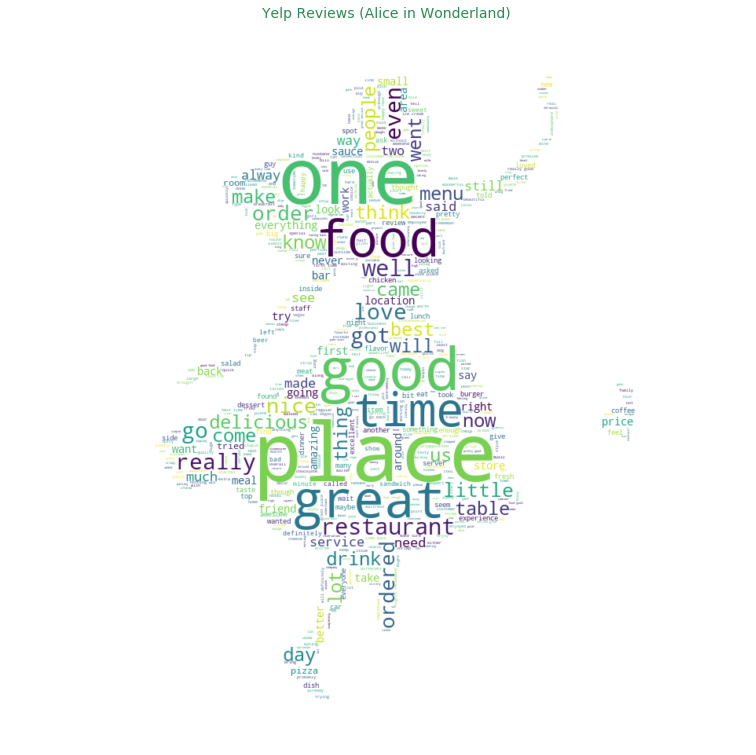

In [59]:
alice_shelley=b'iVBORw0KGgoAAAANSUhEUgAAA4QAAAOECAAAAADcJaDnAAAccklEQVR4nO3d2XbbSLJAUfCu/v9f5n2wVZbECVNmRCD2fuiy3TWAQB5GgqSk230BIv1f9AFAdyKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCKEYCK8hFv0AXCACCGYCK/AICztf9EHwGESLM4khGAiLM8grM52tJQ/wd0f/uT333Z/9qcV/H04ZY9/F5OwoE+z77bcbuZjHXWfMxv6F9b995/cH/+uilf22eO5PhGW8Wu23X/8wUOVP/40t9uzo69x6OewHa3q54bz+e6zyp709uMvD7++OhEW8ekm73Z79jdVWMq3pcZxjuPV0ct4/jppkX3d7d64RJOwhv0LNPvS/m8rmv1AxzEJK+iwPjs8xhdMwsvLvbpfHl3uwz6VCK+v5nKucS97ChEWcLSimhX24Z4wm4c3rCV0dSZhMl3fsO5MhLn87O52+/gm/Y5/K8nYjmbyGIt8GjAJW9ByZiKEYCJMZOC8MgoTE2EeQmlKhGlosCsRQjARQjARptHoE8v8IMI8hlbojjMvESZiFvYkwkxGVmgUpiXCVNpVmPKgZhNhLnakDfkqCuKYg8uymISdpFvy6Q4oiAiTud/77Ej7PNL3RNhIqZ+XVulYDxJhPgMHRKOVXYgIE2qzI23zQN/z8wmTGjazkl3wN48z2ZGOYxImNWwF1tmR1jnSg0SYVZM50ORhviXCtEYtz2QDRoUibChZhYiQYEahCNMaN7CqjMIqx3mUCLMauQKrfHSmyGEeJUKivXnLvkeFIkyqx/JjWUSY1PD9Yq7Gm782I0Iyy/VkMYgIM5qw9HKt7jd3hbkOdAgR5jNn3TVY3FWIkAxa3xWKMJ2eI6rz2xS+21oy119y/GYSQjARkkPjb3UhwrZsfLMQYS6dy2g7CkWYSucG+xJhJhpsSYR9ST4JEZJG15tCESYyezSlG4VNKxQhyV2/TBGm0eGLdj65fnDPiBCCiRCCiTALm9FlabofFWEObgj/6lihCMmtQZUiJLUGDYoQookQgomQzDrsRkVILh1fJRYhmXRsUIQ5xKy9Fnu9AkRIIi0HoQhTMAhfKHCIJ/AduBPo+fz/6OE89GjQJCSNts9FIiSJxwabDEIRkkTbOeieMIGo1ZdrzjRu0CQM13n1/dP6LIiQBFo3aDsaq/fi+/LiLOTaLw9kEnaVfomnP8DTiDBS4CBMtMSfn4VEBzia7Wgce9FlWZwGEQay+JbFWVgW29E4sasv/WYv/QGeyCSMYQAsy/LmNHRq0CRsKseTgAaXZTEJY+RIgCREGCBDg7f4aZPhNKQgwvksvmVZ3p2G8KeHydwTTpelwSzH8aBbgybhbImW/i1wtSc6DfFMwrksvo/aDUIRdhb3jPDmv9yvQdvRqczBZVmcht9Mwoksvs8aDkKT8DT/FXb/87vH1aRBnop8hewaKqcVcfHfn6+Wy9F29KDKDebTskHb0WMkuNXbM9azQRHupL5dnLZnbEd3sZg4j0m4gwR38qLMUyLcRH4HOHkv2I5uYRkN1HYQmoTrKfAY5+8VEa5g+RznHL4mwo8snxN8PIl9N6Mi/EiCJ3AS3xLha5bOOdacx86D0Kujr2nwHM7jJybhC5YOs4jwCQGex7n8TIQPLJsTrTuZre8I3RM+0uB0zRs0CX8Q4Mmc0DVMwm8smZM5oauYhP+xYs628ox2342K8A8Bvrb75zc5qSvZjja2Kq7b3prWzsH2g1CEy7J4zn7j9t//7PkHWcN2tO9i+TyC/js3W789bd+Tukf7SWi5vDbj3NiMmoS8tD/BDf+kBpfuEbYeg2/X/+8zs3Y/2vqM7tV+O8oze1va+s8ZhMvSfBJ62n5iyi6U7xpHaM08en1O3u9Hd55Lg3BZls7bUQ1u8+Z83TR4SNdJKMEnBew6Kc7kYU0jtHKONnjCGTQI/+q7HeWX2Q3ypeUktIKeTKGPJ+XfSzPO37k6RmgNPVpzTk4+b3ajXxpuRzWYggb/028SanB5KCDgnGjwn24RSnBZfhXglERrth214JbFFMqm2yTkl6CnJc8D37SK0BxcluV7AGEnRIPfddqOavCP28MvZtPgD40i1OCX24+/EG3rd/Apy4rLo8uaW6vLPaEG05Dgb022oxokrxaTUIKJGIQP2twTSjGFPsttg0YRLjoM1mqtbdDknpAENPhCr0m4LItxGKDfItukYYQqnKvhCtuo43bUqpjJ2f6oxVsUxNDfOiJkEAmu1XE76p6QVExCzmcIbtIwQoNwMAlu1C1CBQ6nwa2aRajBsQS4R68INTiUBPdpFKECB9PgTo0iZCABHiBCjpPgIY3erL9bKqTU76so3Bqeqd3yGaFfhIsOz9Jx7YzQaDv6j8VzCqfxJC0n4bIsxuExbZfNCC0n4bIsltERXuM6Vd8IVbibM3euvtvRZVnsSbfrvV7GaB6hDDfpvlgGabwdZSsNjtF+Ei6G4UpWyigmodVFMBEuKlzFSRpGhMtiga3gFI0jQtbQ4EAiXJbFR0CIJMK/VEgUEbKCp6iRRMhnGhxKhF/cFr7kzIwlwn+sNUKIEIKJ8Buj8Bn79NFE+J3lRgAR/qDCB07JcCLkLQ2OJ8KfrLmfnI8JRPiLVfedszGDCH+z7pjMT2XiJc9Hc5iEEEyED7w5/ZfzMIkIeUGDs4jwCctvcRImEiFPaXAe3/z3uebfENiqmMkkhGAifK73KOj96KcT4QvWIbOI8JXGFTZ+6CFE+FLbpdj2gUcRIb9ocDYRvmY1MoUI3/ApUmYQIQQTIT+Z/tOJ8C0bUsYT4QcqZDQRQjDfY+aTe/svqWAwk3AFW1JGEuEaKmQgEa6iQsYR4TptKmzzQBMR4UoWJ6OIcC0VMogIIZgIVzMKGUOE63X4IGmDh5iPCLfokCHTiXAbFXI6EW5kGHI2EW6mQs4lQgjmS5m2uy++uokTmYT72JNyGhHudM0Kr/mosrMd3evPerUt5TCT8JhrvWNxqQdThwiPsnA5yHb0sL8V2piyk0l4FhORnUR4mvoV1n8ENYkQgonwNG4K2UeEZ9EgO4nwJBpkLxFCMO8TnsEY5ACTEIKZhCf4bxDen/0hvHfzBu1RTxP88X8UYSkEEeFYhUK0EqLYjo5131ihr1JsyAszx3zMpcx8KXOg1yPCY05euvch/1ZyE2Em94df0IAIE7k//SVXJ8LBNrzGcn/5Gy5NhGnIrisRZhHcoKeAOCJM4iGCud9MUYOBvFk/1spbwugGov/7vZmEQx366IsymhDhSGsblFtrIoRgIkzg1SCcNiBN4lBemAn3poD7nK+n0GAsk3CgVQXFFxB/BM2ZhMOsG2IKwCSM9anBa/38Q57y7S0GOW8ODr4ttADC2Y4OsDobAbDYjo5QqsEMx9CdSXg236SJjUR4LgmymQhPtaXBDBvBDMeAe8IoGdZ/hmPAJDyTvSh7mITnKdegQZiDSXiaTQ1mWP8ZjoFFhKcZNgbLzVe2sh0NkWEIZTgGlsUkPIk5yH4m4RkqpmIQpmESnmBrgxnWf4Zj4A+T8LiBDQ4bsRpMRISHDdyLVtzmspkIE9NgDyI8anMpGXaCGY6BL16YOWb7sFq//g3CJkzCycwgfhPhISOH1cB/t2eCVGxHDxi6X7QZbcMknMsM4oEI99sxq5I0aMqmYju6156FnOGzMqRjErYk8UxEuFPxZVz88K/FdnSX0Wt4fCO3LPeniHAiq56nbEf32DWosjVoR5qFSbjdVVavHWkSJuEsFjwviHASDfKKCDe7ym50udRDqUyEW+1buNsG4bQ4VJiBCDe62LK92MOpSYTbTFm0M8tQYTwRznDftBud24UKw4lwi9uMG8LZVBhNhOmIohufmNlgyhzUYDsm4XpXbVD2wUS42uVeGP33H5VhKNvRsfLPQcKZhGvN+PIlDbYkwnX27djKNKj+SCIcZ9tb9LElqDCQCIfZ+hZ9bAcqjCPCVep+n1/yE+EYW7ei8aMo+r/f2M0T9mcjfwjh7v/E+SyFICbhCCUbzHEQHXmz/rONi9NAYRuT8KPxDWb52FiSw2hHhJ9MaHD7PzJIlmeDZmxHT7VnK2rhdyfCD7YksutuUIPt2Y6+NX5/lqzBZIfTg0l4kp2viaZb9N44ns8kPMX2D8j8ka7BlId0dSJ8p/7PAt0h5UFdmu3ocTZwHOIW4I1VM2H/Ccw7ciyKqWxHXxscSd4GMx/aFdmOHmJkcJxJeMSBBnN/Qiz1wV2OCF8auhCzr/Lsx3cptqOvfFyG196KesVuHhG+0HoOMpXt6F5H7gfPO4pxct+0XopJuI/NGqcxCZ97Pwb2flR0zb87jyrHWZ5J+IwbwmVZluVm4E9hEu7QYg4yjUm4mQQ5l0n4aODrgtUarHa8NYlwK7dJnMwHIx68ffbvtxe1QIZzT/jbqFJKFsgMtqObNBwLnjyGMwl/+vAm/ah/MZ2ZhBsc+E4WhRssfOhFiPCHcS/KFKbCwWxHv3u33GxFGcQk/GZMg5W3on+UfwDJiXCdK35jw/Wu8BgSE+E/b5Za7wav8iiyck/4Zche1OLlMxH+ZQwSxXZ0WZb3L550fWfiB08nA5mEyzJoiV1r3foq+3FEuAx7exBWsR0d9vbg7n+SZtpOwr4/cmkvX3o6StdJuC6SY9/a8Gou+MSSQ8+nt5XLyduDv7RcLOP12o5ui0ODTNEpwo1taJA52mxHN5ehwSe6rJa5rj8JZzdx5Qa9ZT/E1SPcmYS3B5nnOhHmWP05joJS6keYatmnOpgh2ryIMFH9CM9nmTFV8QiTTZ5khzOEUXi60qd0zJr33sQHlZdMSpUn4ZBFb4UxW+EPcGdrsMsg7PNAZ6m6HR20ELw/uErRRZNV0UmYrkHYrWaEg16RsRddqdejHa5khMleFb3Cd7q/uNzXp+Sro99yOe3s2oluUfWlhJxKTsJvzloMFhVh6j+lnTMLj5yG3HudUSotnNuS+nhLbke/O17A0avTs8FyEo+b6tvR+AbJL/k1Lh5hgimU4BBClHvceQ+49nb08Hk9/hSZ99LyS9oNaelJeDSAE763b+MG6z30rEec9tnhs/gxmPWizlJn7XxdqZxHXHc7eqyAnFeDlspuRw81eMrPmPBZtTq+rnfOS1Z0O3oswfAjuIqki+fbtbn//rOMh1xzO7ryZyqFHwEh7sWuTs1J+PkkD35Yxa7yMFlXz+MsvP36fSYl7wmDE7i5G/xS4ETcvv3vz1+lUTLCT+5+uGdz36//7+ryVVjxnvDTWbQV5bv0F6xghKENpr+gfJTudZB0B7TK6xRMwcnyrp+wRbJZzXvCl2dRg7NVPCXZXlmrOQlfXXvvDAZIu4Li301eqWqEj2fYEAySeAWtumjxx1/whZk/fn4qYvSJlGBJRT46U/OecFn+dXdfRr8gmu0WIpnMJyd+yq1Rdjs6TeY1lkOBJfTuIsYfft1JOIch+FmBU5T7I1Qm4WsFFlcSBRbRm4sZfvQm4UsavJLXpYU3KMJX7EM3cK4OsR19wpraLv86enVV44/cJHykQaYS4QMNXlP8xHul7CdmxhAg85mEEEyE33hFdL/8p+7FESbYpXp19I/8ayi95CtpRYO3oAdhEi7LosEzlDyH97e/ncQLM8tSdP1wrrhF0D5C/fXw8ToHLgTbUVhin4ybT0JzsIlPFzp0ITSOUIAny/tKe+a96GI7yomyPq0lb7BvhN6YHyDnOX13VLdPf8MMPbej0WedaVLfDP7VchJmOPHwpd8kVGAnJa523le0RihxSUpLtZw2X+6go281CTXIG2FPIG0iFOAUiXZWda54gwjrXIwrSFNhoct+/QgLXQzOs/WyRz53XD1CCfZUqcGLv0/oYzHzpTjlpRq8eIQESFHhJtE/LibNffQA9VbDRYSvqU1XPvxoL3tPKMDGql38i25Hq10GOrvkJJQgq8XvRq93TyjABCYtqn/X+v78j1fIsP6vth3VYAZzrsKL/8q2/3iGBXOtCL0vmMSM63BKgykqvMw9YYJzyUw/LviRu6qob37/z1UmoQZ7K339LxJh6WvACSqvgPrb0cpn/7rmv+r+979YcTmUn4QVT3oHQdel5HIo/j5hyXPexOCVdeKlj26g7HZUfr1d6fqXjZDe7j8rPHJDGD0Ii0Z4padBTnD/+suOlRHeYMUXZm4+F1PCxKt0f/KrQgpGCMuP8EqW9025V0dNwUJmvEB6f/JnWyQIoNQ9oQD57r7cDjeUoMFS21EN8svjTnRjVBkaLDQJJchF1YhQgDWlf8Uhx/GV2I5qkCFyNJj/uUqBpQUsr/ULJsvaTxyh+q4gc4VZ1n6Ne0JYr9wXFqa9J/TZNA7JMuZWSBqhBK8i7kLWqTBphHDYx8+UZnmmFyHXVWQY5owwy1MUx4VeyxpfYJHzLQoRXkmGJfZ0RWU4sGVJOgk1yMme9ZalwZwRwnhpGrQdZah7/E96+OvPmspxLL+IkFHSLa2ciz3rdjTpyWKLfBcx3xH9kTNC6su64hNKGqErWJ0ruF7SCKEPEUIwEUIwETKEd5nWyxphjU/ewgmyRkh1RuFqeSM0Cmkib4TQhAghmAghWOII3RTSQ+IIVVibl0fXyhwhtalwpdQRGoW1qXCd1BFCByKEYLkj9AlSGsgdodtCGsgeIVyeCBnHy6OrpI/QbSFXlz5CKjMK1ygQoVFYmApXKBAhXJsIIZgIGcp+9DMRQrAKEXplprKbWfhJhQhVyKWViFCFXFmNCKnMfvQDEUIwETKcUfhekQjdFJamwreKRKhCrqtKhCoszSh8p0yElKbCN+pE6Kt7S1Pha3UitCPloipFCJdUKkKjsDD70ZdKRahCrqhWhCoszCh8pViEKixMhS9Ui9A7FVxOuQipyyh8rmCERiHXUjBCFXItFSNUYVW+6dNT/4s+gMn+9msxkEfJSbjf/ddfIV7NCPc2pL1otiBP3Kquyx1X8+dDtRxCVF1vI9WchCs8vKn/+w+shhBem3l01QjvKqOKsq+O3l9vKP+9+nL7/UeQT9l7wmV5VeH919/y+hHaGYWovOSGKL0dfXo1f9/6vbnkVkMIz32/lN2OLsvyY8P557dP/g5IrvQkXH4Ouu3BSTSEUfhT9QihvNIvzHy5LfuHmmflAFdYdCeqfU/4l2tKZbajEKx9hL5nDdHaR2gzSzQRQjAR2pESTIQQTITL4raQUCJclkWFRBLhHyqcyMn+SYR/WRhEESGzeb77RYRfvFExifP8mwghmAj/8RRNCBF+o0IiiPA7FRJAhD+ocDSvfz0S4U/WyFhO7xMihGAi/M1z9Tj2GU+J8IGVwlwiZBrPbs+J8AmLZQin9QURPmO5DOCkviLCpywY5hHhcyo8mzP6kghfsGZO5SXnN0T4ilXDJJf4qUyD+IFNJ7HG3jMJX7OFOofT+IEIGUyDn9iOvmVHepDltYIIP5DhARbXKrajH1hHjGYSfmQW7mJhrSbCFWS4mWW1ge0oBDMJVzELn7kvy9NTY01tYxKuYlk98eekPH6kwcnaSITrWFgP7g+/ePpbPvpf9AFUcbcl/eF5agLcQ4Sr3VX4HwmeyXZ0PWvsy/MNqPOzk1dHNzEMpXY+k3ATX93U/gQMIEK20OAAtqPbdd2TWiqDmISspMFRRLhdz9XY81FPYTu6S7cdqVUykkm4S69F6TXhsUS4j2XJaWxHd2uyJbVAhjMJd+uxOns8ylgi3K/D+uzwGMPZjh5z6T2ptTGHScgrGpxEhMd49Z7DbEdPcMU9qXUxjwjPcLUKLYqpbEchmEl4lstMQytiNhGe5xIZWg/z2Y6e5wrr9wqPoRyT8GSFx6GlEMQkPFnZlewdzzAiPJvFzEa2o4NU2pZaA7FEOEyVDK2AaLajwxRZ3EUO88pMwuHSTkSXPgkRzpCxQxc+DRHOkS1Dlz0REU4WXaPrnY8IZwus0LXOyaujs8WVoMGk/LjsDuSXmgivT4LJ2Y5engazMwmvTH8lmISzTXx1VIM1iBCCiXAyg5DfRDiXBnkgQggmQggmwquyGy1DhBBMhBBMhFNFfzUhGYkQgokQgolwJrtRnhAhBBPhRAYhz4gQgokQgokQgokQgonwonx+uw4RQjARzuMdCp4S4TXZjRYiQggmQggmQggmwktyS1iJCCGYCCGYCKfxNiHPiRCCiRCCiXAWu1FeEGER3nS4LhHWcFfhdYmwgvt9MQuvS4QFyO/aRJjf/ddfuRgRpqe9qxNhdhq8PBEmd3/xa65DhLnprgERpnZ/+1uuQYQQTISZmXwtiDAxDfYgwrw02IQI03rW4F2YFyRCCCbCSc76ml6j8Hr+F30APCe2PkxCCCbCnF4PQiPyckRYzooKhVqKCOfY9rrM+3ciJHYxIrwgldYiwoRE1IsIpzj3O/+K9FpEmM/nxlR4Kd6sz0Zg7ZiEEEyEEEyEyZywG7WhLUaEuQioIRGmosGORAjBRJiJQdiSCGdY+YEZDfYkwjw02JQIJzj3k6Mj/oVEEuF4GuQtEaZhN9qVCLPQYFsiTEKDfYkQgvl6whTMwc5MwuG8lsl7IszAIGxNhKOtGIQa7E2Eg2mQT0QYToPdiRCCiRCCeZ8wmM0oJuFY3iTkIxEO9bFBgxARDmUOsoIIIZgIC7KHvRYRhtqZkwovRYQDjXtZRoVXIsJxgl6WEWg1Igx0IJfX/6gGyxHhMGMHodauQ4RVqfAyRHgx2qzHB7hHGf6JtbsP5FyECMfQB6uJMMo5P5xe7BfgnrC2Xynf3RIWJMIh5g2o+8vfUIXt6AgzN4nCK88kHGBNg9rhiwjPp0E2EeHpvGDJNiI826oGDUL+EeHJzEG2EiEE8xbFqcxBthPhKcTHfrajZ9AgB5iEhymQY0R4iAA5znYUgpmEB5iDnEGEeymQk9iORvCpNb4RYQAN8p3t6D42o5zGJNxFg5xHhBBMhPO5JeQHEUIwEe7hlpATiRCCiRCCiRCCiXA6L47ykwhn0yC/iHAyDfKbCCGYCPcwzjiRCCGYCCGYCOeykeWBCKfSII9ECMFEuMvdSOM0ItxJhZxFhDMplydEuJcdKScR4X4q5BQihGAiPMCOlDOI8BAVcpwIj1Ehh4nwIFtSjhIhBBPhYUYhx4jwODtSDhEhBBPhGYxCDhDhKVTIfiI8hwrZTYQQTIQnMQrZS4RnWVOhHy7KEyI8jVnIPiI8z4oKjUIeifBEKmQPEZ7JjpQdRHgqFbKdCM/1sUL7UX4T4Wwq5BcRnuzzhlSF/CTCs/nqQjYS4Xw3s5DvRHg+O1I2EeEANqRsIcIRvFHBBjfP2oN86Mx554tJOMqHysxCvogwigr563/RB3Bdd6GxikkYxtuF/CHCkbz6wgoiHMpn2PhMhIOpkE9EOJoK+UCEw9mS8p4IJ5Ah74gQgvns6DQPbws69SzLYhJO9HtTqkH+EOFE95e/oTPbUQhmEkIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUIwEUKw/wf0n8IA+qpuMAAAAABJRU5ErkJggg=='

import imageio
import codecs
from wordcloud import WordCloud, STOPWORDS
f2 = open("mws.png", "wb")
f2.write(codecs.decode(alice_shelley,'base64'))
f2.close()
img2 = imageio.imread("mws.png")
alice_mask = img2

wc = WordCloud(background_color="white", max_words=5000, mask=alice_mask,
               stopwords=STOPWORDS)
# generate word cloud
wc.generate(" ".join(texts[:10000]))

# show
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Yelp Reviews (Alice in Wonderland)", fontsize=14,color='seagreen')
plt.axis("off");


In [77]:
# X_train, X_test, Y_train, Y_test = train_test_split(texts,labels,random_state=1)

### Getting everything ready for LSTM

In [140]:
max_features = 10000
maxlen = 100

In [141]:
list_sentences_train = reviews["text"].fillna("CVxTz").values
y = reviews['labels'].values

In [142]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)

X_t = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)


In [143]:
def get_model():
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [145]:
# Run
model = get_model()
batch_size = 128
epochs = 1


file_path="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=20)


callbacks_list = [checkpoint, early] #early
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list,verbose=1)


Train on 239228 samples, validate on 26581 samples
Epoch 1/1
239228/239228 [==============================] - 623s 3ms/step - loss: 0.1607 - acc: 0.9356 - val_loss: 0.1161 - val_acc: 0.9560


### Predict on our news file

In [174]:
news_list_sentences_train = news["text_cleaned"].fillna("CVxTz").values

In [175]:
tokenizer_news = text.Tokenizer(num_words=max_features)
tokenizer_news.fit_on_texts(list(news_list_sentences_train))
news_list_tokenized_train = tokenizer.texts_to_sequences(news_list_sentences_train)

X_news = sequence.pad_sequences(news_list_tokenized_train, maxlen=maxlen)

In [176]:
news_lables_pred = model.predict(X_news)

In [177]:
news['pred_class'] = news_lables_pred
news['labels'] = news["pred_class"].apply(lambda x: 1 if x >= .5  else 0)
news.head()

,crawled,language,text,title,date,text_clean,title_clean,pred_class,labels,text_cleaned
0,2018-01-22T06:31:13.011+02:00,english,Discussion in ' Midwest ' started by sportscra...,Best Stops Chicago Red Line?,2018-01-22,Discussion in Midwest started by sportscraze...,Best Stops Chicago Red Line,0.967705,1,"discussion midwest start sportscrazed2 , jan 2..."
1,2018-01-22T06:43:12.000+02:00,english,CHICAGO – Hundreds of ballet dancers between t...,AP PHOTOS: Talented young dancers compete in C...,2018-01-22,CHICAGO Hundreds of ballet dancers between th...,AP PHOTOS: Talented young dancers compete in C...,0.043615,0,chicago hundred ballet dancer age 9 19 auditio...
2,2018-01-22T06:52:12.009+02:00,english,Chicago rapper Fredo Santana has reportedly di...,Chicago Rapper Fredo Santana Reportedly Dead A...,2018-01-22,Chicago rapper Fredo Santana has reportedly di...,Chicago Rapper Fredo Santana Reportedly Dead A...,0.748191,1,"chicago rapper fredo santana reportedly die , ..."
3,2018-01-22T06:53:16.017+02:00,english,E-mail \nPolice are searching for a 27-year-ol...,"Man, 27, reported missing from Rogers Park | C...",2018-01-22,Email Police are searching for a 27yearold man...,"Man, 27, reported missing from Rogers Park Ch...",0.228336,0,email police search 27yearold man go miss roge...
4,2018-01-22T06:54:04.067+02:00,english,Documentary about Miss Continental pageant set...,Documentary about Miss Continental pageant set...,2018-01-22,Documentary about Miss Continental pageant set...,Documentary about Miss Continental pageant set...,0.009578,0,documentary miss continental pageant set debut...


### Pull out positive and negative

### Word clouds

In [178]:
pos_news = news['text_cleaned'][news['labels']==1]

In [179]:
neg_news = news['text_cleaned'][news['labels']==0]

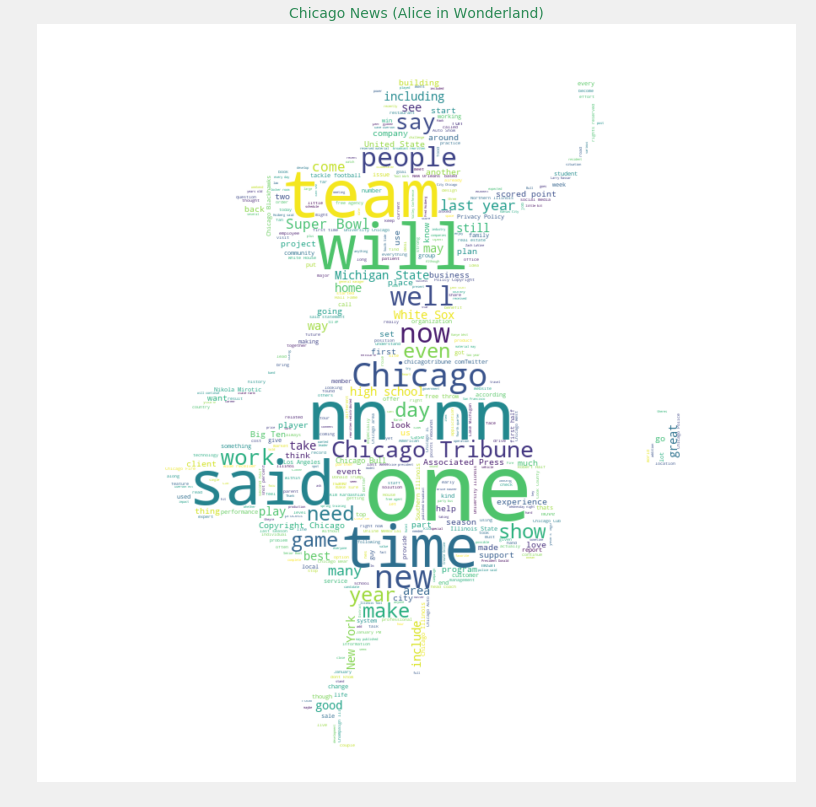

In [180]:
# positive
f2 = open("mws.png", "wb")
f2.write(codecs.decode(alice_shelley,'base64'))
f2.close()
img2 = imageio.imread("mws.png")
alice_mask = img2

wc = WordCloud(background_color="white", max_words=5000, mask=alice_mask,
               stopwords=STOPWORDS)
# generate word cloud
wc.generate(" ".join(pos_news[:10000]))

# show
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Chicago News (Alice in Wonderland)", fontsize=14,color='seagreen')
plt.axis("off");


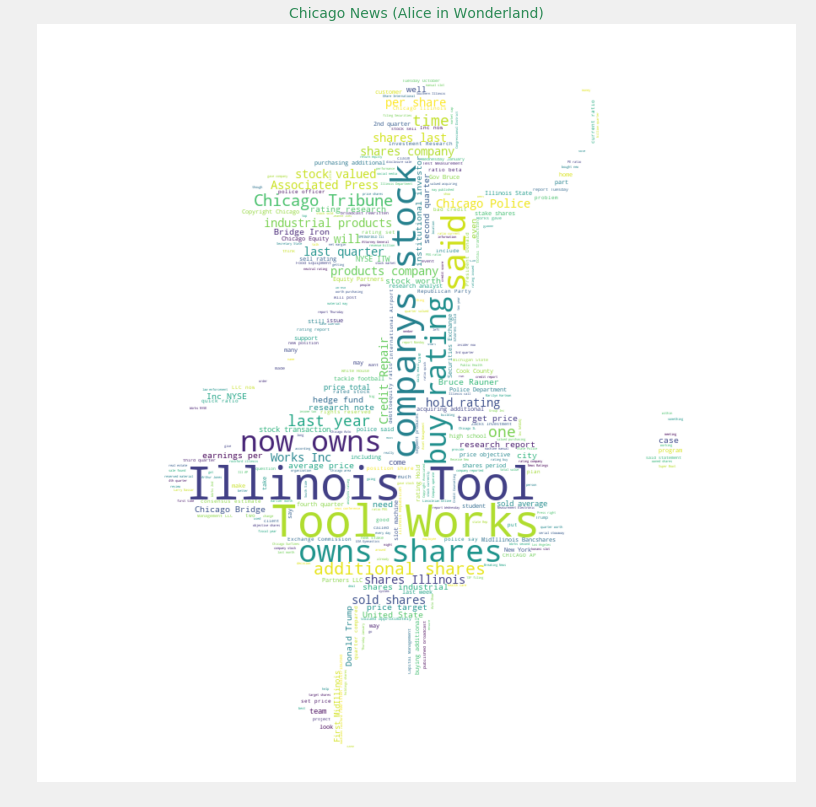

In [181]:
# negative
f2 = open("mws.png", "wb")
f2.write(codecs.decode(alice_shelley,'base64'))
f2.close()
img2 = imageio.imread("mws.png")
alice_mask = img2

wc = WordCloud(background_color="white", max_words=5000, mask=alice_mask,
               stopwords=STOPWORDS)
# generate word cloud
wc.generate(" ".join(neg_news[:10000]))

# show
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Chicago News (Alice in Wonderland)", fontsize=14,color='seagreen')
plt.axis("off");
